In [1]:
import sys
import os

# Source: https://stackoverflow.com/questions/16780014/import-file-from-parent-directory
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__name__))))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from lusi.svm import SVMRandomInvariants
from lusi.types import InvariantTypes

In [2]:
# Generate datasets
datasets = [
    make_circles(1000, noise=0.1, factor=0.5, random_state=47),
    make_moons(1000, noise=0.05, random_state=47),
]

In [3]:
def plot_datasets(datasets, titles):
    figure = plt.figure(figsize=(12,5))
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    for i in range(len(datasets)):
        X, y = datasets[i]
        plt.subplot(1, 2, i+1)
        plt.title(titles[i])
        plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')
    
    plt.show()

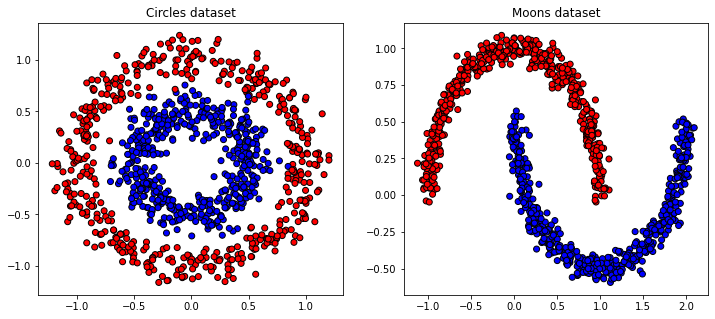

In [4]:
plot_datasets(datasets, ['Circles dataset', 'Moons dataset'])

In [5]:
# Foreach dataset (2 datasets)
# Try C parameter (3-4 values should be enough)
# Test num_invariants paramter (2-4 values should be enough)
# Test tau paramter (2-3 values should be enough)
# Test invariant type

## Testing hyperparameters

In [6]:
def plot_decision_boundary(clf, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
    y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    viz=np.c_[xx.ravel(),yy.ravel()]
    Z = clf.predict_proba(viz, clip=False)
    Z = Z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, levels=np.linspace(-1.3,2.3,13), cmap=cm, alpha=.8)
    plt.contour(xx, yy, Z, levels=[0.5], linestyles='dashed')
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cm_bright, edgecolors='k')
    plt.tight_layout()
    plt.title('Decision boundary')
    plt.show()

X, y = datasets[0]

Number of selected invariants:  2
Accuracy:  0.9922222222222222


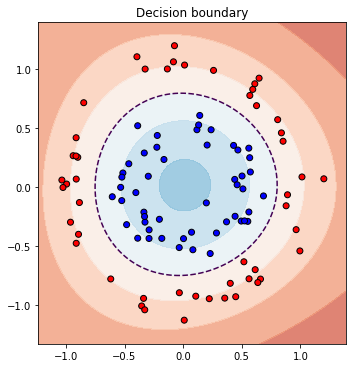

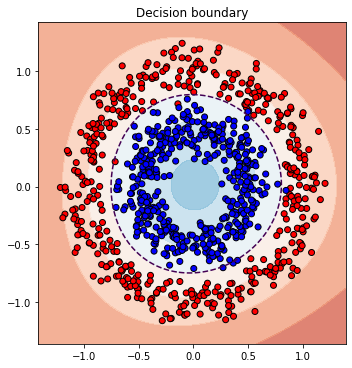

Number of selected invariants:  10
Accuracy:  0.9877777777777778


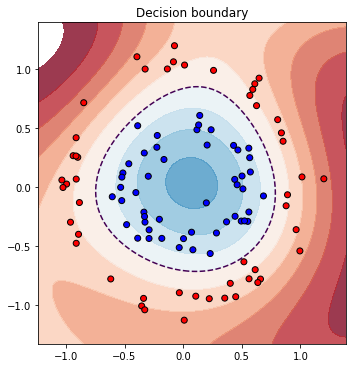

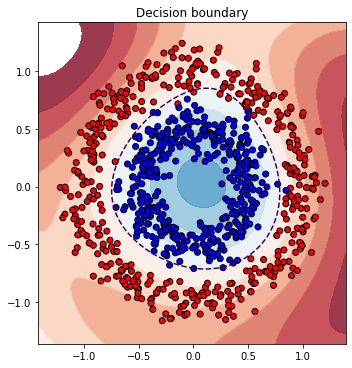

Number of selected invariants:  2
Accuracy:  0.9922222222222222


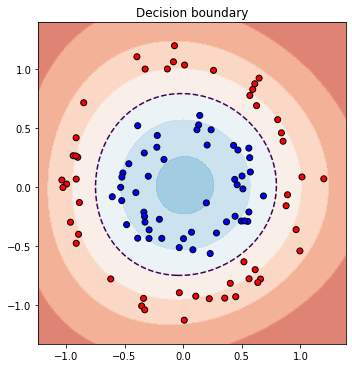

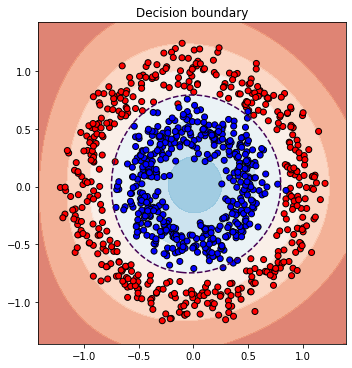

Number of selected invariants:  2
Accuracy:  0.96


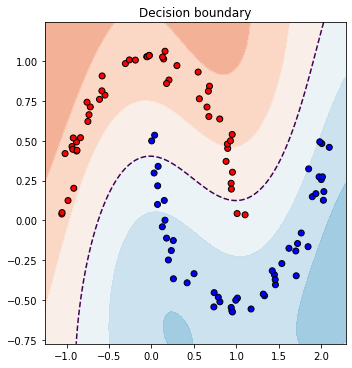

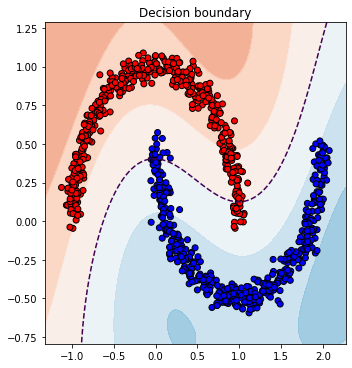

Number of selected invariants:  10
Accuracy:  0.9966666666666667


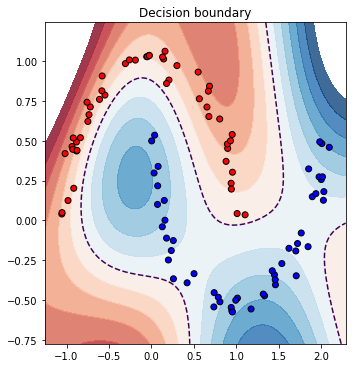

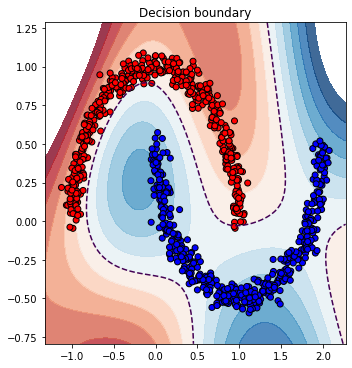

Number of selected invariants:  2
Accuracy:  0.9588888888888889


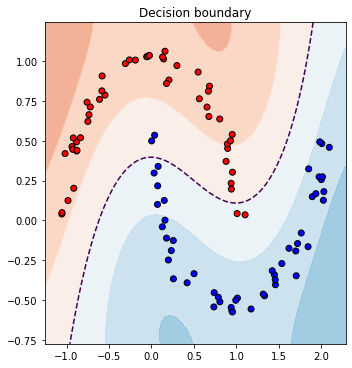

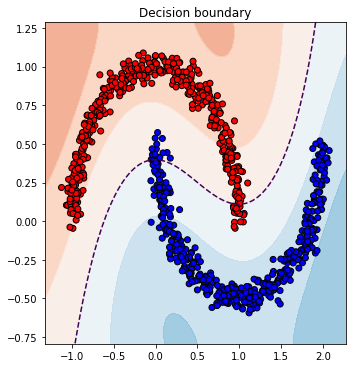

In [7]:
invariant_types = [InvariantTypes.PROJECTION, InvariantTypes.HYPERPLANE, InvariantTypes.VAPNIK]

for dataset in datasets:
    X, y = dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=0.1,
        stratify=y,
        random_state=47,
    )
    
    for invariant_type in invariant_types:
        clf = SVMRandomInvariants(num_invariants=10, invariant_type=invariant_type)
        clf.fit(X_train, y_train)
        print("Number of selected invariants: ", len(clf.invariants))
        
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print("Accuracy: ", acc)

        plot_decision_boundary(clf, X_train, y_train)
        plot_decision_boundary(clf, X_test, y_test)

In [14]:
from collections import Counter

seeds = [42, 47, 194, 8923, 293, 7892, 9123, 923184, 83291, 193927]

for dataset, title in zip(datasets, ["CIRCLES DATASET", "MOONS DATASET"]):
    X, y = dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=0.1,
        stratify=y,
        random_state=47,
    )
    
    n_selected = {
        InvariantTypes.PROJECTION: [],
        InvariantTypes.HYPERPLANE: [],
        InvariantTypes.VAPNIK: [],
    }

    first_selected = {
        InvariantTypes.PROJECTION: [],
        InvariantTypes.HYPERPLANE: [],
        InvariantTypes.VAPNIK: [],
    }
    
    max_selected = {
        InvariantTypes.PROJECTION: [],
        InvariantTypes.HYPERPLANE: [],
        InvariantTypes.VAPNIK: [],
    }
    
    accuracies = []

    for seed in seeds:
        clf = SVMRandomInvariants(num_invariants=50, invariant_type=InvariantTypes.ALL, random_state=seed)
        clf.fit(X_train, y_train)
        invariants = clf.invariants
        
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))
        
        selected_counts = Counter(invariant['type'] for invariant in invariants)
        
        first_invariants = invariants[:10]
        first_counts = Counter(invariant['type'] for invariant in first_invariants)
        
        max_first = sorted(invariants, key=lambda x: -x['T_value'])[:10]
        max_counts = Counter(invariant['type'] for invariant in max_first)
        
        for type_key in n_selected.keys():
            n_selected[type_key].append(selected_counts[type_key] if type_key in selected_counts.keys() else 0)
            first_selected[type_key].append(first_counts[type_key] if type_key in first_counts.keys() else 0)
            max_selected[type_key].append(max_counts[type_key] if type_key in max_counts.keys() else 0)

    print(f"\n\n------------ {title} ------------\n\n")
    print("\n----- Accuracy information ------")
    print("\n\nAccuracies: ", accuracies)
    print("Mean accuracy: ", np.mean(accuracies))
    print("Min accuracy: ", np.min(accuracies))
    print("Max accuracy: ", np.max(accuracies))
    print("Std: ", np.std(accuracies))

    print("\n----- Invariants information ------")

    for type_key in n_selected.keys():
        print("\n\nInformation for invariant type ", type_key)
        print("Number of times selected: ", n_selected[type_key])
        print("Mean number of times selected: ", np.mean(n_selected[type_key]))
        print("Number of times selected among the first 10: ", first_selected[type_key])
        print("Mean number of times selected among the first 10: ", np.round(np.mean(first_selected[type_key])))
        print("Number of times selected with the maximum values: ", max_selected[type_key])
        print("Mean number of times selected with the maximum values: ", np.round(np.mean(max_selected[type_key])))



------------ CIRCLES DATASET ------------



----- Accuracy information ------


Accuracies:  [0.8522222222222222, 0.8122222222222222, 0.8988888888888888, 0.8611111111111112, 0.85, 0.87, 0.8622222222222222, 0.8244444444444444, 0.8544444444444445, 0.8377777777777777]
Mean accuracy:  0.8523333333333334
Min accuracy:  0.8122222222222222
Max accuracy:  0.8988888888888888
Std:  0.02294087946477389

----- Invariants information ------


Information for invariant type  InvariantTypes.PROJECTION
Number of times selected:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Mean number of times selected:  2.0
Number of times selected among the first 10:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Mean number of times selected among the first 10:  2.0
Number of times selected with the maximum values:  [0, 2, 2, 0, 1, 2, 1, 2, 2, 1]
Mean number of times selected with the maximum values:  1.0


Information for invariant type  InvariantTypes.HYPERPLANE
Number of times selected:  [48, 48, 48, 48, 48, 48, 48, 48, 48, 48]
Mean numb